# 0) Setups

In [1]:
# import libraries
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# reading data inside xml file to a variable under the name data
with open('Uniklinikum_Freiburg_map.osm', 'r') as f:
    data = f.read()
 
# passing stored data inside beautifulsoup parser, storing the returned object 
bs_data = BeautifulSoup(data, "xml")

# 1) Nodes

In [3]:
# store all nodes in a dictionary and give them a label
nds = {}
for node in bs_data.select('node'):
    # first case: store has a name
    if node.find('tag', k='name'):
        # map node id to a tuple of (lat, lon, name)
        nds[node['id']] = (node['lat'], node['lon'], node.find('tag', k='name').get('v'))
    else:
        nds[node['id']] = (node['lat'], node['lon'], None)

# print the number of total nodes      
print('The map includes {} total nodes.'.format(len(nds.keys())))

The map includes 1790 total nodes.


In [4]:
# print the first node
print('The first node is: {}'.format(nds[list(nds.keys())[0]]))

The first node is: ('48.0095474', '7.8372915', None)


In [5]:
# create dictionary of all nodes that have a name and map id to name
named_nodes = {k: v[2] for k, v in nds.items() if v[2]}

In [16]:
list(named_nodes.values())

['Emmaus Kapelle',
 'Neurozentrum',
 'Augenklinik / HNO',
 'Neurozentrum',
 'Café am Eck',
 'Bistro am Lorenzring',
 'Kiosk Frauenklinik',
 'Stimme vom Berg',
 'Klinik für Frauenheilkunde',
 'Klinik für Frauenheilkunde',
 'Sympathy',
 'Zwischen den Räumen',
 'Terrakotta',
 'Freischwimmer',
 'Notaufnahme',
 'Tripylon',
 'Hermann Nothnagel',
 'Paracelsus',
 'Herman Boerhaave',
 'Johann Lukas Schönlein',
 'Hippokrates von Kos',
 'Theodor Billroth',
 'Ernst von Bergmann',
 'Joseph Lister',
 'Ambroise Paré',
 'Guy de Chauliac',
 'Adolf Lorenz',
 'Creativ Coiffeur Löffler']

# 2) Ways

In [6]:
# store all ways in a dictionary and give them a label according to their highway type
ways = {}
for way in bs_data.select('way'):
    # filter out ways that don't have a highway tag
    if way.find('tag', k='highway'):
        # map way id to a tuple of (list of node ids, highway type)
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           way.find('tag', k='highway').get('v'))
    else:
        ways[way['id']] = ([nd['ref'] for nd in way.find_all('nd')],
                           None)

In [7]:
# list with all possible values of the key 'highway'
highways = list(set([way[1] for way in ways.values() if way[1] is not None]))
# print the different highway types
print('The different highway types are: {}'.format(highways))

The different highway types are: ['cycleway', 'path', 'service', 'construction', 'pedestrian', 'unclassified', 'footway', 'steps']


# 3) Footprints of buildings

In [8]:
# store all foorprints in a dictionary
footprints = {}
for way in bs_data.select('way'):
    # filter out ways that don't have a building tag
    if way.find('tag', k='building'):
        footprints[way['id']] = [nd['ref'] for nd in way.find_all('nd')]

# print the number of footprints
print('The map includes {} footprints in total.'.format(len(footprints.keys())))

The map includes 40 footprints in total.


# 4) Graph

In [9]:
# define necesssary parameters for the graph
params = {
    'named_nodes': ['Neurozentrum', 'Café am Eck', 'Bistro am Lorenzring'], # default: named_nodes.values()
    'highways': ['pedestrian', 'steps', 'construction', 'footway', 'path', 'service'], # default: highways
    'footprints': True # default: True
}

In [22]:
# create a graph for the different types of highways
G_highways = nx.Graph()

if params['highways'] is not None:
    for way_id, (nodes, highway_type) in ways.items():
        # filter out ways that don't have a highway tag
        if highway_type in params['highways']:
            G_highways.add_edges_from(zip(nodes[:-1], nodes[1:]))

tbd: check if all nodes and egdes are really included, why zip(nodes[:-1], nodes[1:]) ?
Answer: self loops

! Not every node in params['highways'] is part of an edge. Think about a dictionary that maps every node in named_node to the closest node that is part of an edge. !

In [23]:
# create a dictionary that maps every created edge to its highway type
edge_labels_highways = {}
# iterate over all edges that are highways
for u, v in G_highways.edges():
    # iterate over all ways
    for way_id, (nodes, highway_type) in ways.items():
        # check if the edge is in a way and add the highway type to the dictionary
        if u in nodes and v in nodes:
            edge_labels_highways[(u, v)] = highway_type

! At the moment every edge maps to a unique highway type.
Think about mapping to a list that includes several highway types. !

In [24]:
# create graph with footprints
G_footprints = nx.Graph()
if params['footprints']:
    # iterate over all footprints and add them to the graph
    for footprint_id, nodes in footprints.items():
        G_footprints.add_edges_from(zip(nodes[:-1], nodes[1:]))

In [25]:
# combine the single graphs for the plot
G = nx.Graph()
# add nodes and edges from the two graphs to the combined graph
G.add_nodes_from(G_highways.nodes)
G.add_nodes_from(G_footprints.nodes)
G.add_edges_from(G_highways.edges)
G.add_edges_from(G_footprints.edges)

# add further nodes that have a name as key attribute but are not part of any way
if params['named_nodes'] is not None:
    for node_id, name in [item for item in named_nodes.items() if item[1] in params['named_nodes']]:
        if node_id not in G.nodes:
            G.add_node(node_id, name=name)

# 5) Plot

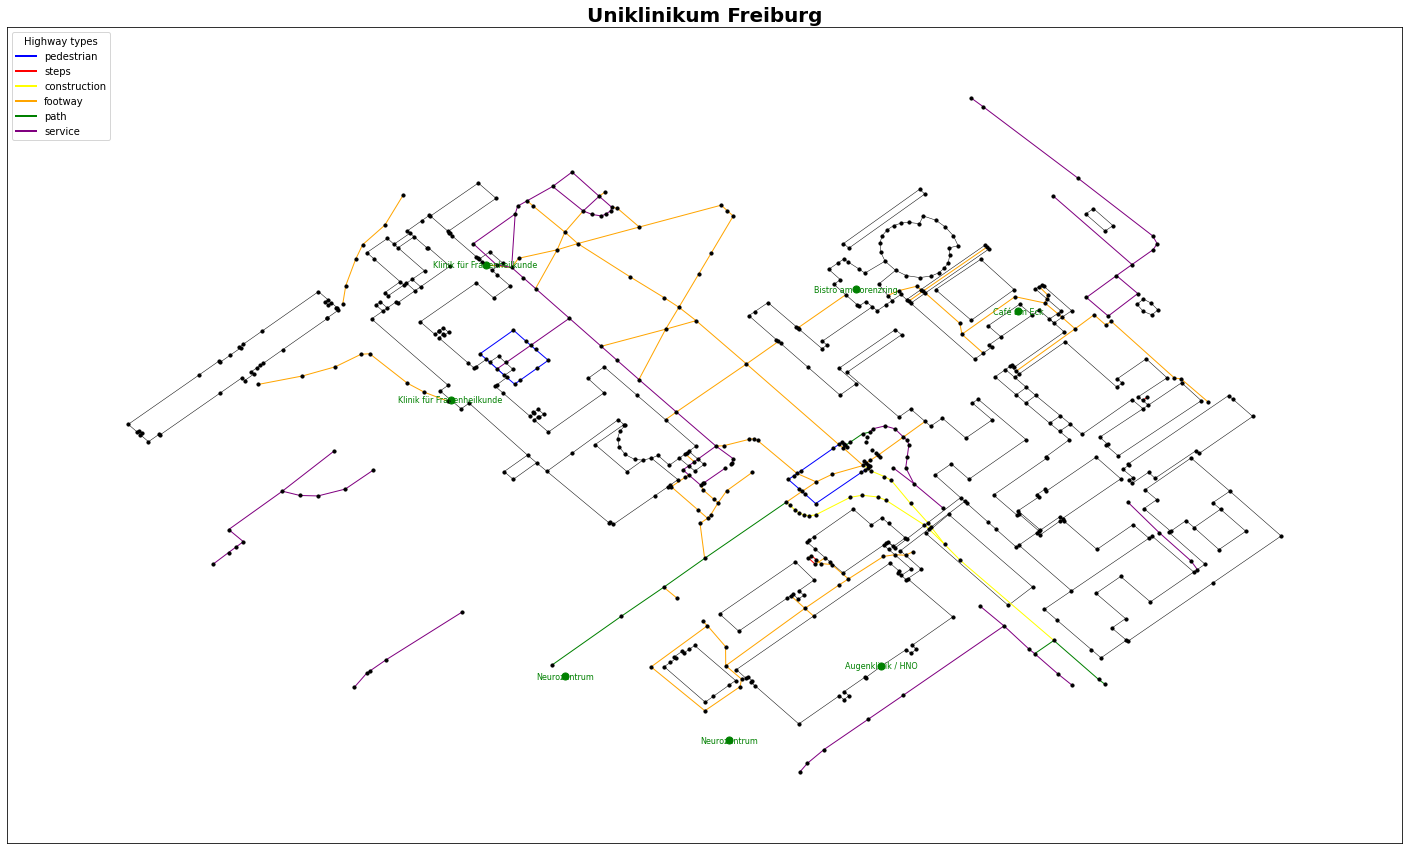

In [26]:
# define colors for the different highway types
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'purple', 'pink', 'brown']

# plot the graph where all nodes are placed at their geographical position
pos = {key: (float(value[0]), float(value[1])) for key, value in nds.items()}
plt.figure(figsize=(25, 15))

# plot only nodes that have a name
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if nds[node][2] is not None and node in named_nodes],
                       node_color='green', node_size=50)
# label them
nx.draw_networkx_labels(G, pos, labels={node: nds[node][2] for node in G.nodes if nds[node][2] is not None and node in named_nodes},
                        font_size=8, font_color='green')
# add all other nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes if nds[node][2] is None],
                       node_color='black', node_size=10)
# add edges from the footprints graph
nx.draw_networkx_edges(G, pos, edgelist=G_footprints.edges, edge_color='black', width=0.5)
# add edges from the highways graph
if params['highways'] is not None:
    for i, highway_type in enumerate(params['highways']):
        nx.draw_networkx_edges(G, pos, edgelist=[edge for edge in G_highways.edges if edge_labels_highways[edge] == highway_type],
                            edge_color=colors[i], width=1)

# plot the graph
plt.title('Uniklinikum Freiburg', fontsize=20, fontweight='bold')
# legend that described colors and highway types
if params['highways'] is not None:
    plt.legend([plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(params['highways']))],
            params['highways'], fontsize=10, title='Highway types', loc='upper left')
plt.show()

tbd: Add weights according to euclidean distance.